# Анализ статистической мощности. Оценка вероятности обнаружения эффекта методом Монте-Карло.

### Задание 1.
ML планируют выкатывать новый алгоритм, рекомендующий пользователям интересные посты. 
Основные фичи:
- Алгоритм добавляет пользователям 1-2 просмотра
- Вероятность того, что он сработает, составляет 90%
- Если у пользователя меньше 50 просмотров, то алгоритм не сработает

Предполагается, что увеличение числа просмотров приведёт к увеличению лайков на пользователя.  

**Вопрос:** сможем ли мы обнаружить различия в среднем количестве лайков на пользователя?  
**Решение:** проведём симуляцию Монте-Карло.

In [17]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline
rng = np.random.default_rng()
from tqdm import tqdm
import os

In [3]:
# Подключаемся к схеме данных ленты новостей
connection = {
    'host': os.getenv('HOST'),
    'database': os.getenv('DATABASE'),
    'user': os.getenv('USER_NAME'),
    'password': os.getenv('PASSWORD')
}

# Рассчитаем просмотры для каждого пользователя

q_views = """
select views, count() as users
from (select  
    user_id,
    sum(action = 'view') as views
FROM {db}.feed_actions 
where toDate(time) between '2024-04-26' and '2024-05-02'
group by user_id
)
group by views
order by views
"""

views_distribution = ph.read_clickhouse(q_views, connection=connection)

In [4]:
# Кол-во уникальных пользователей за период А/А теста
views_distribution.users.sum()

41997

In [5]:
# Посчитаем кол-во пользователей для выборки эксперимента (50/50 за время А/А теста)
n_size = int(round(views_distribution.users.sum()/2,0))
n_size

20998

In [6]:
# Посчитаем вероятности просмотров
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
15,16,545,0.012977
14,15,537,0.012787
13,14,500,0.011906
34,35,485,0.011548
29,30,469,0.011167
...,...,...,...
280,287,1,0.000024
278,285,1,0.000024
276,280,1,0.000024
1,2,1,0.000024


<Axes: xlabel='views', ylabel='users'>

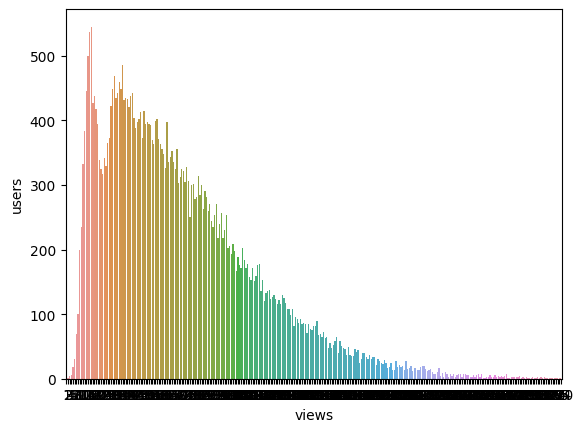

In [7]:
# Визуализируем распределения просмотров
sns.barplot(x=views_distribution['views'], y=views_distribution['users'])

In [8]:
# Достанем распределение CTR за неделю
q_ctr = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from {db}.feed_actions
where dt between '2024-04-26' and '2024-05-02'
group by dt, user_id
)
group by ctr
"""

ctr_distribution = ph.read_clickhouse(q_ctr, connection=connection)

In [9]:
# Вычислим верояности CTR
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
17,0.20,4993,0.058658
33,0.16,4233,0.049729
50,0.25,4216,0.049529
6,0.18,4213,0.049494
72,0.21,3957,0.046487
...,...,...,...
27,0.69,2,0.000023
73,0.83,1,0.000012
20,0.73,1,0.000012
51,1.00,1,0.000012


In [10]:
# Проведем симуляцию 20000 раз для алгоритма версии №1 (group_B_views >= 50)
n_sim = 20000
n_size = int(round(views_distribution.users.sum()/2,0))
pv = np.array([])

for _ in tqdm(range(n_sim)):
    group_A_views = rng.choice(views_distribution['views'], size=(n_size), replace=True, p=views_distribution['p']).astype("int64")
    group_B_views = rng.choice(views_distribution['views'], size=(n_size), replace=True, p=views_distribution['p']).astype("int64")
    group_B_views = (group_B_views + ((1 + rng.binomial(n=1, p=0.5, size=n_size)) * rng.binomial(n=1, p=0.9, size=n_size) * (group_B_views >= 50))).astype("int64")

    group_A_ctr = rng.choice(ctr_distribution['ctr'], size=(n_size), replace=True, p=ctr_distribution['p'])
    group_B_ctr = rng.choice(ctr_distribution['ctr'], size=(n_size), replace=True, p=ctr_distribution['p'])

    clicks_A = rng.binomial(group_A_views, group_A_ctr).astype("int32")
    clicks_B = rng.binomial(group_B_views, group_B_ctr).astype("int32")
    pv = np.append(pv, stats.ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

100%|████████████████████████████████████| 20000/20000 [03:07<00:00, 106.95it/s]


In [14]:
# Рассчитаем мощность теста
power_v0 = round(np.mean(pv<= 0.05)*100,0)
power_v0

26.0

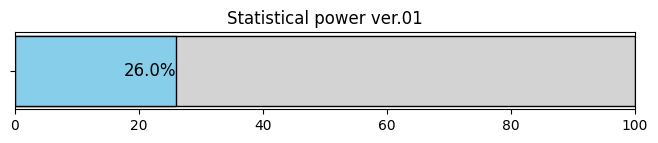

In [29]:
# Визуализируем результат
current_progress = power_v0  # Текущий прогресс в процентах
goal = 100  # Цель в процентах

# Визуализация полоски прогресса
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh([''], [goal], color='lightgray', edgecolor='black')
ax.barh([''], [current_progress], color='skyblue', edgecolor='black')

# Настройка осей и заголовка
ax.set_xlim(0, 100)
ax.set_title('Statistical power ver.01')
ax.text(current_progress, 0, f'{current_progress}%', va='center', ha='right', fontsize=12, color='black')

plt.show()

**Ответ:** Мощность теста 26% - слишком мала, чтобы верно оценить эффект

### Задание 2.
ML улучшили качество алгоритма, теперь он срабатывает на пользователях с числом просмотров от 30 и выше, т.е:
- Алгоритм добавляет пользователям 1-2 просмотра
- Вероятность того, что он сработает, составляет 90%
- Если у пользователя меньше 30 просмотров, то алгоритм не сработает

In [30]:
# Проведем симуляцию 20000 раз для алгоритма версии №2 (group_B_views >= 30)
# n_sim = 20000
# n_size = int(round(views_distribution.users.sum()/2,0))
pv = np.array([])

for _ in tqdm(range(n_sim)):
    group_A_views = rng.choice(views_distribution['views'], size=(n_size), replace=True, p=views_distribution['p']).astype("int64")
    group_B_views = rng.choice(views_distribution['views'], size=(n_size), replace=True, p=views_distribution['p']).astype("int64")
    group_B_views = (group_B_views + ((1 + rng.binomial(n=1, p=0.5, size=n_size)) * rng.binomial(n=1, p=0.9, size=n_size) * (group_B_views >= 30))).astype("int64")

    group_A_ctr = rng.choice(ctr_distribution['ctr'], size=(n_size), replace=True, p=ctr_distribution['p'])
    group_B_ctr = rng.choice(ctr_distribution['ctr'], size=(n_size), replace=True, p=ctr_distribution['p'])

    clicks_A = rng.binomial(group_A_views, group_A_ctr).astype("int32")
    clicks_B = rng.binomial(group_B_views, group_B_ctr).astype("int32")
    pv = np.append(pv, stats.ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

100%|████████████████████████████████████| 20000/20000 [03:06<00:00, 107.19it/s]


In [31]:
# Рассчитаем мощность теста
power_v1 = round(np.mean(pv<= 0.05)*100,0)
power_v1

42.0

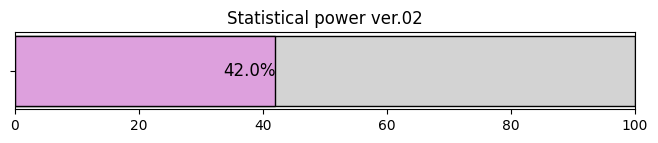

In [33]:
# Визуализируем результат
current_progress = power_v1  # Текущий прогресс в процентах
goal = 100  # Цель в процентах

# Визуализация полоски прогресса
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh([''], [goal], color='lightgray', edgecolor='black')
ax.barh([''], [current_progress], color='plum', edgecolor='black')

# Настройка осей и заголовка
ax.set_xlim(0, 100)
ax.set_title('Statistical power ver.02')
ax.text(current_progress, 0, f'{current_progress}%', va='center', ha='right', fontsize=12, color='black')

plt.show()

**Ответ:** Мощность теста 42% - лучше, но по-прежнему мало, чтобы верно обнаружить эффект.

### Задание 3.
Нам утвердили длительность эксперимента длиной в 2 недели.
Теперь допустим, что в эти две недели к нам придёт столько же пользователей, сколько пришло суммарно за период АА-теста и АБ-теста (с 2024-04-26 по 2024-05-09).  
Рассчитаем мощность теста.

In [10]:
# Пересчитаем кол-во пользователей за 2 недели

q_users = """
select  count(distinct user_id) as users
FROM {db}.feed_actions 
where toDate(time) between '2024-04-26' and '2024-05-09'
"""

users_qty = ph.read_clickhouse(q_users, connection=connection)
users_qty

,users
0,61182


In [11]:
# Пересчитаем кол-во пользователей для выборки эксперимента (50/50 за время А/А и A/B теста)
n2_size = int(round(users_qty.users.sum()/2,0))
n2_size

30591

In [36]:
# Проведем симуляцию 20000 раз для алгоритма версии №3 (group_B_views >= 30 & n_size = 30591)
n_sim = 20000
n_size = int(round(users_qty.users.sum()/2,0))
pv = np.array([])

for _ in tqdm(range(n_sim)):
    group_A_views = rng.choice(views_distribution['views'], size=(n_size), replace=True, p=views_distribution['p']).astype("int64")
    group_B_views = rng.choice(views_distribution['views'], size=(n_size), replace=True, p=views_distribution['p']).astype("int64")
    group_B_views = (group_B_views + ((1 + rng.binomial(n=1, p=0.5, size=n_size)) * rng.binomial(n=1, p=0.9, size=n_size) * (group_B_views >= 30))).astype("int64")

    group_A_ctr = rng.choice(ctr_distribution['ctr'], size=(n_size), replace=True, p=ctr_distribution['p'])
    group_B_ctr = rng.choice(ctr_distribution['ctr'], size=(n_size), replace=True, p=ctr_distribution['p'])

    clicks_A = rng.binomial(group_A_views, group_A_ctr).astype("int32")
    clicks_B = rng.binomial(group_B_views, group_B_ctr).astype("int32")
    pv = np.append(pv, stats.ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

100%|█████████████████████████████████████| 20000/20000 [04:30<00:00, 73.81it/s]


In [37]:
# Рассчитаем мощность теста
np.mean(pv<= 0.05)

0.5596

In [38]:
# Рассчитаем мощность теста
power_v2 = round(np.mean(pv<= 0.05)*100,0)
power_v2

56.0

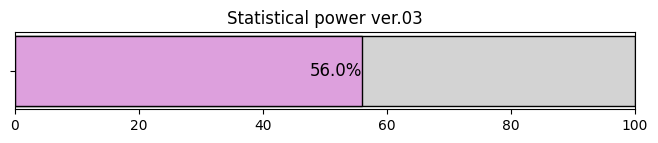

In [39]:
# Визуализируем результат
current_progress = power_v2  # Текущий прогресс в процентах
goal = 100  # Цель в процентах

# Визуализация полоски прогресса
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh([''], [goal], color='lightgray', edgecolor='black')
ax.barh([''], [current_progress], color='plum', edgecolor='black')

# Настройка осей и заголовка
ax.set_xlim(0, 100)
ax.set_title('Statistical power ver.03')
ax.text(current_progress, 0, f'{current_progress}%', va='center', ha='right', fontsize=12, color='black')

plt.show()

**Ответ:** Мощность теста 56% - Еще лучше, но по-прежнему мало, чтобы верно оценить эффект

### Задание 4.
Будем отбирать только нужных пользователей, отсеим их таким образом:

mask_A = group_A_views >= 30  
mask_B = group_B_views >= 30

scipy.stats.ttest_ind(group_A_likes[mask_A], group_B_likes[mask_B], equal_var=False)

In [13]:
# Проведем симуляцию 20000 раз для алгоритма версии №4 
# (group_B_views >= 30, n_size = 30591, group_A_views >= 30 & group_B_views >= 30 )

n_sim = 20000
n_size = int(round(users_qty.users.sum()/2,0))
pv = np.array([])

for _ in tqdm(range(n_sim)):
    group_A_views = rng.choice(views_distribution['views'], size=(n_size), replace=True, p=views_distribution['p']).astype("int64")
    group_B_views = rng.choice(views_distribution['views'], size=(n_size), replace=True, p=views_distribution['p']).astype("int64")
    group_B_views = (group_B_views + ((1 + rng.binomial(n=1, p=0.5, size=n_size)) * rng.binomial(n=1, p=0.9, size=n_size) * (group_B_views >= 30))).astype("int64")

    group_A_ctr = rng.choice(ctr_distribution['ctr'], size=(n_size), replace=True, p=ctr_distribution['p'])
    group_B_ctr = rng.choice(ctr_distribution['ctr'], size=(n_size), replace=True, p=ctr_distribution['p'])

    clicks_A = rng.binomial(group_A_views, group_A_ctr).astype("int32")
    clicks_B = rng.binomial(group_B_views, group_B_ctr).astype("int32")
    
    mask_A = group_A_views >= 30 
    mask_B = group_B_views >= 30
    pv = np.append(pv, stats.ttest_ind(clicks_A[mask_A], clicks_B[mask_B], equal_var=False).pvalue)

100%|█████████████████████████████████████| 20000/20000 [04:31<00:00, 73.56it/s]


In [14]:
# Рассчитаем мощность теста
np.mean(pv<= 0.05)

0.64215

In [15]:
# Рассчитаем мощность теста
power_v3 = round(np.mean(pv<= 0.05)*100,0)
power_v3

64.0

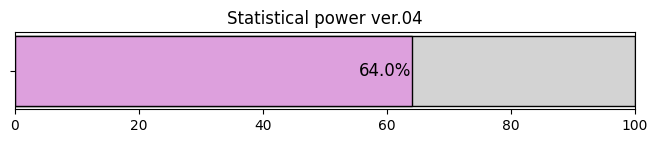

In [16]:
# Визуализируем результат
current_progress = power_v3  # Текущий прогресс в процентах
goal = 100  # Цель в процентах

# Визуализация полоски прогресса
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh([''], [goal], color='lightgray', edgecolor='black')
ax.barh([''], [current_progress], color='plum', edgecolor='black')

# Настройка осей и заголовка
ax.set_xlim(0, 100)
ax.set_title('Statistical power ver.04')
ax.text(current_progress, 0, f'{current_progress}%', va='center', ha='right', fontsize=12, color='black')

plt.show()

**Ответ:** Мощность теста 64% - хороший результат, но так и не дотягивает до общепринятого стандарта в 80% мощности, так как это разумный баланс между риском альфа- и бета-ошибок.